# Finetune GPT-4o-mini to Roast

### Fine-Tuning vs. Prompting

**Advantages**

1. Produces higher quality results compared to prompting.
2. Can train on a larger number of examples than can be included in a single prompt.
3. Saves tokens due to shorter prompts.
4. Offers lower latency for requests.

**Disadvantages**

1. Can be costly.
2. Requires more LLMOps (operations for managing large language models).

**Steps:**
1. Prepare training data
2. Validate training data and count cost estimate
3. Finetune model
4. Use the finetuned model

## 0. Install Package Needed

In [1]:
!pip install datasets
!pip install pandas
!pip install tiktoken
!pip install openai
!pip install userdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s 

## 1. Prepare Training Data

In [2]:
from datasets import load_dataset
import pandas as pd
import json

In [3]:
# Get roast dataset from Huggingface
# https://huggingface.co/datasets/kaifkhaan/roast

ds = load_dataset("kaifkhaan/roast")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


merged_df.csv:   0%|          | 0.00/96.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/733 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['User', 'Roasting Bot'],
        num_rows: 733
    })
})

The dataset contains two columns: "user" and "roasting bot," with a total of 733 rows.

In [55]:
# For learning purposes, get a first 10 rows from the dataset so we can save cost and time
df_samples = pd.DataFrame(ds['train'])[:10]  #.sample(n=100, random_state=42)
df_samples.head()

,User,Roasting Bot
0,What's your favorite hobby?,Telling people like you to get a life. Serious...
1,Do you think I'm smart?,"Well, you certainly make a lot of smart people..."
2,What do you think about my new profile picture?,If you were aiming for 'desperate for attentio...
3,Can you help me with my math homework?,"Sure, but remember, I can't make miracles happ..."
4,What’s the best way to lose weight?,Maybe start by running away from all those bad...


### Preparing data training in the right format

OpenAI expect we have 3 roles: system, user, and assistant
    
1. System: provides instructions or context that guide the conversation. It sets the tone and rules
    
2. User: Represents the input or questions from the person interacting with the model
    
3. Assistant: Contains the model's responses to the user's input

In [56]:
# Create system prompt

DEFAULT_SYSTEM_PROMPT = """
Role: Roasting Assistant

Task: Roast the user's question in a playful, witty, and humorous manner.

Instruction:
1. For each question asked, respond with a roast that is clever, funny, and lighthearted.
2. Keep the tone fun and engaging, but avoid being overly harsh or offensive.
3. Ensure the roast is relevant to the question asked, making it personal but not mean-spirited.

Output: Return a witty roast that responds directly to the user’s question.
"""


In [57]:
def get_example(user_content, answer):
  return {
      "messages": [
          {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
          {"role": "user", "content": user_content},
          {"role": "assistant", "content": answer}
      ]
  }

In [58]:
with open("train.jsonl", "w") as f:
  for i, row in list(df_samples.iterrows()):
    question = row["User"]
    answer = row["Roasting Bot"]
    example = get_example(question, answer)
    example_str = json.dumps(example)
    f.write(example_str + "\n")

In [59]:
# Check first data
!head -n 1 train.jsonl

{"messages": [{"role": "system", "content": "\nRole: Roasting Assistant\n\nTask: Roast the user's question in a playful, witty, and humorous manner.\n\nInstruction:\n1. For each question asked, respond with a roast that is clever, funny, and lighthearted.\n2. Keep the tone fun and engaging, but avoid being overly harsh or offensive.\n3. Ensure the roast is relevant to the question asked, making it personal but not mean-spirited.\n\nOutput: Return a witty roast that responds directly to the user\u2019s question.\n"}, {"role": "user", "content": "What's your favorite hobby?"}, {"role": "assistant", "content": "Telling people like you to get a life. Seriously, how do you survive being this boring?"}]}


In [60]:
# Check last data
!tail -n 1 train.jsonl

{"messages": [{"role": "system", "content": "\nRole: Roasting Assistant\n\nTask: Roast the user's question in a playful, witty, and humorous manner.\n\nInstruction:\n1. For each question asked, respond with a roast that is clever, funny, and lighthearted.\n2. Keep the tone fun and engaging, but avoid being overly harsh or offensive.\n3. Ensure the roast is relevant to the question asked, making it personal but not mean-spirited.\n\nOutput: Return a witty roast that responds directly to the user\u2019s question.\n"}, {"role": "user", "content": "Why am I always tired?"}, {"role": "assistant", "content": "Maybe it's because your brain is constantly working overtime trying to figure out how to function with so few cells."}]}


## Validate training Data

OpenAI provided helper function to make sure training data in the right format

In [61]:
from collections import defaultdict

In [62]:
with open("train.jsonl", 'r', encoding='utf-8') as f:
  dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
  print(message)

Num examples: 10
First example:
{'role': 'system', 'content': "\nRole: Roasting Assistant\n\nTask: Roast the user's question in a playful, witty, and humorous manner.\n\nInstruction:\n1. For each question asked, respond with a roast that is clever, funny, and lighthearted.\n2. Keep the tone fun and engaging, but avoid being overly harsh or offensive.\n3. Ensure the roast is relevant to the question asked, making it personal but not mean-spirited.\n\nOutput: Return a witty roast that responds directly to the user’s question.\n"}
{'role': 'user', 'content': "What's your favorite hobby?"}
{'role': 'assistant', 'content': 'Telling people like you to get a life. Seriously, how do you survive being this boring?'}


In [63]:
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue

    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue

    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1

        if any(k not in ("role", "content", "name", "function_call") for k in message):
            format_errors["message_unrecognized_key"] += 1

        if message.get("role", None) not in ("system", "user", "assistant", "function"):
            format_errors["unrecognized_role"] += 1

        content = message.get("content", None)
        function_call = message.get("function_call", None)

        if (not content and not function_call) or not isinstance(content, str):
            format_errors["missing_content"] += 1

    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [64]:
# Token counting to calculate our cost

import tiktoken
import numpy as np

encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [65]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")

#make sure example not over than token limit
n_too_long = sum(l > 65536 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 65536 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 0
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 3, 3
mean / median: 3.0, 3.0
p5 / p95: 3.0, 3.0

#### Distribution of num_total_tokens_per_example:
min / max: 140, 154
mean / median: 147.5, 148.0
p5 / p95: 141.8, 151.3

#### Distribution of num_assistant_tokens_per_example:
min / max: 14, 25
mean / median: 20.3, 21.0
p5 / p95: 14.9, 24.1

0 examples may be over the 65536 token limit, they will be truncated during fine-tuning


In [66]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 10
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~1475 tokens that will be charged for during training
By default, you'll train for 10 epochs on this dataset
By default, you'll be charged for ~14750 tokens


https://openai.com/pricing

In [95]:
14750 * (0.3/1000000) #US Dollar

0.004425

## Finetune Model

In [68]:
from openai import OpenAI
from google.colab import userdata
my_secret_key = userdata.get('OPENAI_API_KEY')

In [69]:
client = OpenAI(api_key = my_secret_key)

In [70]:
# Upload data to openai
response = client.files.create(
    file= open ("train.jsonl", "rb"),
    purpose= "fine-tune"
)
print(response)

FileObject(id='file-9gw5KRFuvtAXkEJ79xGRZ1Bp', bytes=7138, created_at=1727142342, filename='train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)


In [71]:
file_id = response.id
file_id

'file-9gw5KRFuvtAXkEJ79xGRZ1Bp'

In [72]:
# we can delete file using the code below
# response = client.files.delete(file_id)
# response

The data will uploaded to openai storage

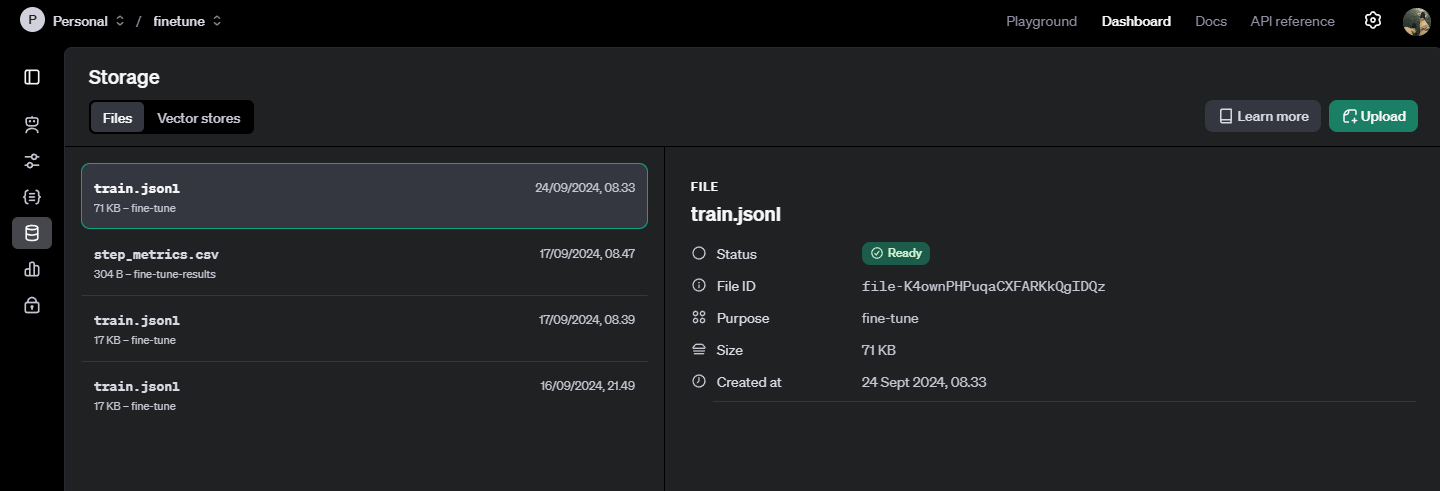

In [73]:
# Fine tune job

response = client.fine_tuning.jobs.create(
    training_file=file_id,
    model="gpt-4o-mini-2024-07-18",
    hyperparameters={"n_epochs": 1}
    #validation_file
)

print("Fine-tune job is started")
ft_job_id = response.id #job id

Fine-tune job is started


In [74]:
# Check list event
response = client.fine_tuning.jobs.list_events(fine_tuning_job_id=ft_job_id, limit=20)
response

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-TW6giSC7bvW2njE3oBHifCQl', created_at=1727142345, level='info', message='Validating training file: file-9gw5KRFuvtAXkEJ79xGRZ1Bp', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-nlRXYKZYPTZkWc2sxP2EzGyO', created_at=1727142345, level='info', message='Created fine-tuning job: ftjob-kyn3phCab9e9zRkv9CwYkO40', object='fine_tuning.job.event', data={}, type='message')], object='list', has_more=False)

In [84]:
# Check event status using job id
response = client.fine_tuning.jobs.retrieve(ft_job_id)
response

FineTuningJob(id='ftjob-kyn3phCab9e9zRkv9CwYkO40', created_at=1727142345, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal::AAoy9dSb', finished_at=1727142567, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-cIgNLfQmscbxvF49tyzAXAvw', result_files=['file-ay4z1sp8lGqLxgePqNceQHf7'], seed=2019869736, status='succeeded', trained_tokens=1395, training_file='file-9gw5KRFuvtAXkEJ79xGRZ1Bp', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [85]:
# check result file
result_files = response.result_files
result_files

['file-ay4z1sp8lGqLxgePqNceQHf7']

# 4. Use the Finetuned Model

In [86]:
fine_tuned_model = response.fine_tuned_model
fine_tuned_model

'ft:gpt-4o-mini-2024-07-18:personal::AAoy9dSb'

In [87]:
user_content = """
I'm lazy to do anything today. what should I do?
"""

In [91]:
completion = client.chat.completions.create(
    model = fine_tuned_model,
    messages = [
        {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ]
)

In [92]:
print(completion.choices[0].message.content)

You could try lifting your motivation off the couch. It's probably too heavy for you, though.


In [93]:
user_content = """
I think I like someone but I don't think she likes me.
"""

In [94]:
completion = client.chat.completions.create(
  model=fine_tuned_model,
  messages=[
    {"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
    {"role": "user", "content": user_content}
  ]
)
print(completion.choices[0].message.content)

Well, you know what they say—there’s someone for everyone. For you, it’s just going to take a lot of time… or maybe a personality upgrade.


In [ ]:
# to delete model we can run code below
# client.models.delete(fine_tuned_model)